# Import Library

In [1]:
# analisis dan visualisasi data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


In [2]:
# Text Preprocessing
!pip install swifter
import re
import string
import nltk
import swifter
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from collections import Counter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=bf610307a588536ca7350d39dfd133e8378394edabf9fc788a0b1ab697e79fe2
  Stored in directory: /root/.cache/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built swifter


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.8 MB/s eta 0:00:00


In [3]:
# Modeling
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [4]:
# Inference/testing
import joblib
from tensorflow.keras.models import load_model

# Load Data

In [5]:
url = 'https://drive.google.com/uc?id=1vYWMa3Vl5fnCpFEP5QvMOqZRebLQwptI'
df = pd.read_csv(url)
df.head()

,app,userName,score,content,at,thumbsUpCount
0,Traveloka,Labib Nur Diansyah,5,cepat,2025-04-07 10:33:58,0
1,Traveloka,Agus Sutrisno,3,sangat cepat dan mudah,2025-04-07 10:06:06,0
2,Traveloka,Hamdika Ainun Rais,1,spek hotel di aplikasi tidak sesuai dengan ken...,2025-04-07 07:40:36,0
3,Traveloka,Irwan 14,1,"dikasih limit sampai 35 juta,tapi buat belanja...",2025-04-07 06:01:40,22
4,Traveloka,Ipoel ulum,5,bagus,2025-04-07 05:29:01,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   app            15000 non-null  object
 1   userName       15000 non-null  object
 2   score          15000 non-null  int64 
 3   content        15000 non-null  object
 4   at             15000 non-null  object
 5   thumbsUpCount  15000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 703.3+ KB


**Insight Data Loading :**

- Dataset memiliki data ulasan sebanyak 15.000 data ulasan, yang diambil dari apk Gojek di Google Playstore
- Memiliki 6 fitur awal

**Keterangan fitur:**

---

| No | Nama Kolom               | Keterangan                                                                 |
|----|--------------------------|----------------------------------------------------------------------------|
| 1  | `app`               | Jenis Aplikasi                                        |
| 2  | `userName`               | Nama pengguna yang memberikan ulasan                                      |
| 3  | `userImage`              | URL foto profil pengguna (gambar akun)                                    |                                  |
| 4  | `score`                  | Skor/rating yang diberikan (1-5)                                          |
| 5  | `thumbsUpCount`          | Jumlah pengguna lain yang memberi "like" atau setuju dengan ulasan tersebut |
| 6  | `reviewCreatedVersion`  | Versi aplikasi saat ulasan ditulis (tidak semua pengguna menyertakan ini) |
| 7  | `at`                     | Tanggal dan waktu ulasan dibuat                                           |

# Data preprocessing & Cleaning

In [7]:
# Pilih kolom untuk analisis sentimen
pilih_kolom = ['userName', 'thumbsUpCount', 'at']
df.drop(columns=pilih_kolom, inplace=True)
df.head()

,app,score,content
0,Traveloka,5,cepat
1,Traveloka,3,sangat cepat dan mudah
2,Traveloka,1,spek hotel di aplikasi tidak sesuai dengan ken...
3,Traveloka,1,"dikasih limit sampai 35 juta,tapi buat belanja..."
4,Traveloka,5,bagus


In [8]:
# Missing Values & Duplicates
# Tidak ada Missing Values
# drop data duplicate
print(df.duplicated().sum())
df = df.drop_duplicates()
print("Jumlah data setelah menghapus duplikat:", len(df))

4033
Jumlah data setelah menghapus duplikat: 10967


**Insight Preprocessing & Cleaning**
1. Tidak ada Missing Values
2. Data duplikat di drop sehingga jumlah data yang akan digunakan 11238
3. Menggunakan/memilih fitur App, Content, dan Score untuk analisis sentimen
- Kolom Content digunakan untuk analisis sentimen
- Kolom Score digunakan untuk label sentimen (score 1–2 = Negatif, 3 = Netral, 4–5 = Positif).


# Text Preprocessing + Pelabelan

In [9]:
# Gabungkan semua teks jadi satu string besar
all_text = ' '.join(df['content'].dropna().astype(str).str.lower().values)

# Tokenisasi dan ambil frekuensi tiap kata
words = all_text.split()
word_freq = Counter(words)

# Lihat kata-kata paling sering muncul
common_words = word_freq.most_common(200)
for word, freq in common_words:
    print(f"{word}: {freq}")

dan: 3009
sangat: 2983
aplikasi: 2620
di: 2505
traveloka: 2115
saya: 2033
tiket: 1721
yang: 1506
untuk: 1354
tidak: 1342
membantu: 1315
bisa: 1200
yg: 1173
bagus: 1135
nya: 1066
ini: 1043
ada: 1019
mudah: 920
hotel: 911
banyak: 776
mau: 755
sudah: 675
gak: 606
dengan: 595
ke: 560
ga: 558
refund: 530
buat: 515
banget: 514
lebih: 513
harga: 511
jadi: 497
sekali: 492
juga: 479
pesan: 468
tapi: 463
dari: 440
pesawat: 439
memudahkan: 421
lagi: 403
dalam: 399
aplikasinya: 395
apk: 386
promo: 384
selalu: 377
perjalanan: 360
mantap: 356
padahal: 337
pakai: 336
kita: 334
bayar: 331
beli: 327
cepat: 322
sama: 321
aja: 314
paylater: 307
pembayaran: 285
kasih: 284
baik: 277
,: 277
malah: 275
udah: 271
pake: 271
tolong: 262
pihak: 261
saat: 258
karena: 258
liburan: 246
suka: 240
uang: 237
baru: 233
kenapa: 233
traveloka,: 227
hari: 225
lama: 218
ya: 216
itu: 215
atau: 214
booking: 213
sy: 213
mencari: 213
kalau: 212
lain: 210
pas: 204
pemesanan: 204
kecewa: 203
pernah: 203
ribet: 203
bagus,: 202
pe

In [10]:
# Slang_dict
slang_dict = {
    'yg': 'yang',
    'gak': 'tidak',
    'ga': 'tidak',
    'nya': '',
    'mau': 'ingin',
    'udah': 'sudah',
    'aja': 'saja',
    'banget': 'sangat',
    'buat': 'untuk',
    'pake': 'pakai',
    'tolong': 'mohon',
    'sy': 'saya',
    'ya': 'iya',
    'kenapa': 'mengapa',
    'kalo': 'kalau',
    'gk': 'tidak',
    'semoga': 'mudah-mudahan',
    'apa': 'apa',
    'pesen': 'pesan',
    'tp': 'tapi',
    'aku': 'saya',
    'kok': 'mengapa',
    'minta': 'meminta',
    'gampang': 'mudah',
    'makin': 'semakin',
    'bgt': 'banget',
    'd': 'di',
    'ok': 'oke',
    'sdh': 'sudah',
    'udh': 'sudah',
    'pun': 'juga',
    'cuma': 'hanya',
    'utk': 'untuk',
    'cek': 'periksa',
    'lah': '',
    'kan': '',
    'in': 'dalam',
    '👍': '',
    'aja': 'saja',
    'tdk': 'tidak',
    'dgn': 'dengan'
}


In [11]:
# Inisialisasi tools
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian')).union(set(stopwords.words('english')))
stop_words.update([
    'iya','yaa','gak','nya','na','sih','ku','di','ga','ya','gaa',
    'loh','kah','woi','woii','woy'])
stem_cache = {}

In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ').translate(str.maketrans('', '', string.punctuation)).strip()
    return text

def normalize_slang(text):
    words = text.split()
    fixed_words = []
    for word in words:
        if word.lower() in slang_dict:
            fixed_words.append(slang_dict[word.lower()])
        else:
            fixed_words.append(word)
    fixed_text = ' '.join(fixed_words)
    return fixed_text

def stem_word(word):
    if word in stem_cache:
        return stem_cache[word]
    stemmed = stemmer.stem(word)
    stem_cache[word] = stemmed
    return stemmed


def preprocess_text(text):
    text = clean_text(text)
    text = normalize_slang(text).strip()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    stemmed_tokens = [stem_word(word) for word in tokens]
    return ' '.join(stemmed_tokens)

# Terapkan ke dataframe
df['preprocessed'] = df['content'].swifter.apply(preprocess_text)
df[['content', 'preprocessed']].head()


Pandas Apply:   0%|          | 0/10967 [00:00<?, ?it/s]

,content,preprocessed
0,cepat,cepat
1,sangat cepat dan mudah,cepat mudah
2,spek hotel di aplikasi tidak sesuai dengan ken...,spek hotel aplikasi sesuai nyata refund
3,"dikasih limit sampai 35 juta,tapi buat belanja...",kasih limit jutatapi belanja online butuh hidu...
4,bagus,bagus


In [13]:
df['text_clean'] = df['content'].apply(clean_text)
df['text_slang_normalized'] = df['text_clean'].apply(normalize_slang)
df['text_tokenized'] = df['text_slang_normalized'].apply(word_tokenize)
df['text_filtered'] = df['text_tokenized'].apply(lambda tokens: [word for word in tokens if word not in stop_words and len(word) > 1])
df['text_stemmed'] = df['text_filtered'].apply(lambda tokens: [stem_word(word) for word in tokens])
df['text_akhir'] = df['text_stemmed'].apply(lambda tokens: ' '.join(tokens))
df['preprocessed'] = df['content'].swifter.apply(preprocess_text)


Pandas Apply:   0%|          | 0/10967 [00:00<?, ?it/s]

In [14]:
positive_word = {
    "bagus" : 5, "mantap" : 5, "terbaik" : 5, "mudah" : 3, "aman" : 4,
    "cepat" : 4, "top" : 5, "suka" : 3, "promo" : 5, "praktis" : 5,
    "keren" : 5, "oke" : 2, "bagus" : 5 , "helpful" : 4, "bantu" : 4,
    "terpercaya" : 5, "berguna" : 5, "akurat" : 5, "amanah" : 4,
    "usefull" : 2, "mudah dipakai" : 4, "memudahkan" : 4, "sangat membantu" : 5,
    "sangat cepat" : 5, "seru": 5, "menyenangkan": 4, "keren": 5, "ringan": 4,
    "hebat": 5, "asyik": 4, "menarik": 4, "lancar": 4, "smooth": 4, "epic": 5,
    "top": 5, "menghibur": 4, "unik": 3, "addictive": 5, "fantastis": 5,
    "luar biasa": 5, "memuaskan": 4, "realistis": 3, "menantang": 3,
    "menakjubkan": 5, "kocak": 4, "greget": 4, "mengasyikkan": 4,
    "sangat berguna" : 5, "tidak perlu ke agen" : 2, "nyaman" : 3,
    "normal kembali" : 4, "sesuai" : 3, "tidak ribet" : 4
}

negative_word = {
    "refund" : -10 , "ditolak" : -5, "gagal" : -7, "tidak bisa" : -3, "mahal" : -7,
    "turun" : -2, "limit" : -3, "salah" : -1, "kecewa" : -15, "zonk" : -10,
    "tidak sesuai" : -7, "jebakan" : -8, "tidak jelas" : -10, "tidak fungsional" : -10,
    "tidak fungsi" : -10, "hangus" : -7, "tidak menghargai waktu" : -6, "tidak sinkron" : -7,
    "terlambat" : -5, "lambat" : -6, "mengganggu" : -9, "iklan" : -3, "mengecewakan" : -4,
    "kelalaian'" : -7, "tidak ada" : -3, "hapus" : -3, "fitur belum beres" : -3,
    "lag": -5, "bug": -4, "jebakan": -5, "ganggu": -4, "tidak jelas": -10,
    "crash": -15, "error": -4, "lambat": -3, "lemot": -3, "buruk": -4, "parah": -5,
    "membosankan": -4, "tidak menarik": -3, "tidak adil": -4,"payah": -5,
    "menyedihkan": -3, "sampah": -5, "tidak seru": -3, "pelit": -4, "toxic": -4,
    "tidak balance": -3, "terlalu sulit": -3,"tidak responsive": -4,
    "kontrol buruk": -4, "penuh iklan": -4,"sering keluar sendiri": -5,
    "salah tanggal" : -3,"tidak meyakinkan" : -5
}

In [15]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:
        if word in positive_word:
            score += positive_word[word]
        elif word in negative_word:
            score += negative_word[word]

    # Menentukan polaritas berdasarkan skor akhir
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

# Terapkan ke DataFrame
results = df['text_stemmed'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df['polarity_score'] = results[0]
df['polarity'] = results[1]

# Cek distribusi label sentimen
print(df['polarity'].value_counts())


polarity
positive    5331
neutral     4260
negative    1376
Name: count, dtype: int64


In [16]:
# Fungsi Analisis Sentimen + Pelabelan
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if word in positive_word:
            score += positive_word[word]
        elif word in negative_word:
            score += negative_word[word]

    if score > 0:
        polarity = 'positif'
    elif score < 0:
        polarity = 'negatif'
    else:
        polarity = 'netral'

    return score, polarity

results = df['text_stemmed'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df['polarity_score'] = results[0]
df['polarity'] = results[1]

# Gabungkan token ke dalam string untuk WordCloud
df['preprocessed'] = df['text_stemmed'].apply(lambda tokens: ' '.join(tokens))

**Insight Text Preprocessing dan Pelabelan**
1. slang_dict adalah dictionary yang digunakan untuk mengatasi bahasa gaul/tidak baku agar menjadi bahasa yang baku saat analisis sentimen
2. Tahapan preprocessing text yang dilakukan :
- Lowercasing: Ubah teks jadi huruf kecil.
- Pembersihan Karakter: Hapus mention, hashtag, RT, link, angka, dan simbol.
- Normalisasi Slang: Ganti kata tidak baku pakai kamus slang_dict.
- Tokenisasi: Pecah kalimat jadi kata-kata.
- Stopword Removal: Hapus kata umum yang kurang bermakna.
- Stemming: Ubah kata ke bentuk dasar (contoh: "membantu" → "bantu").
3. Pelabelan
Pelabelan dilakukan menggunakan pendekatan lexicon-based, dengan daftar kata positif dan negatif yang disusun secara manual. Setiap kata memiliki skor tertentu.
- Kata Positif: Diberi skor positif
- Kata Negatif: Diberi skor negatif
- Skoring Sentimen:
-- Jika total skor > 0 → Positif
-- Jika skor < 0 → Negatif
-- Jika skor = 0 → Netral

# Exploratory Data Analysis (EDA)

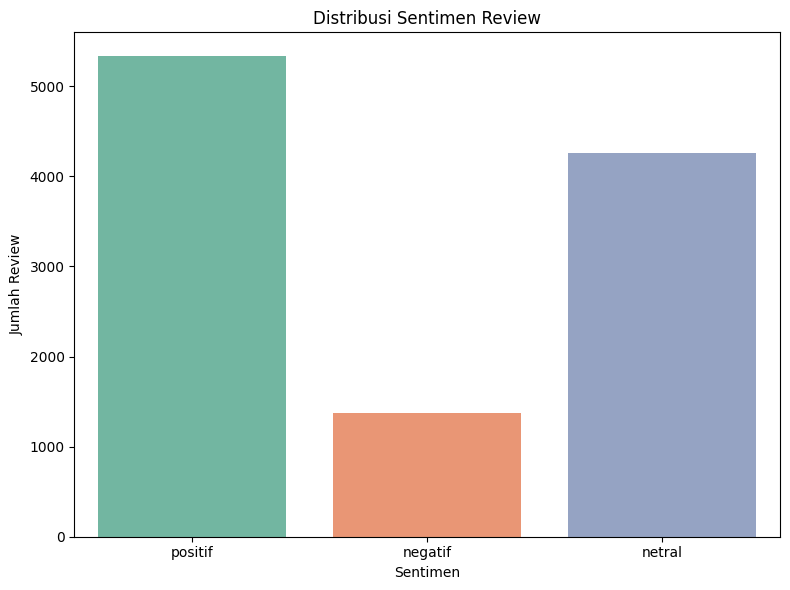

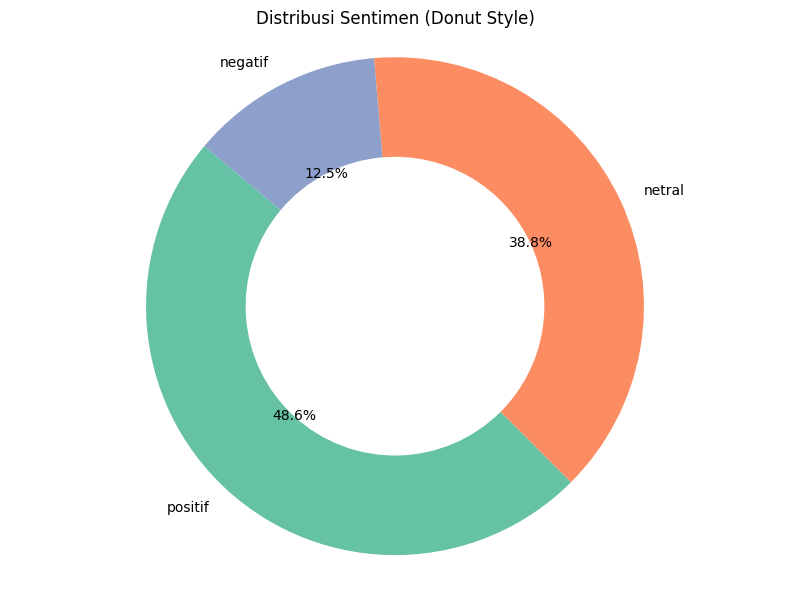

In [17]:
# Distribusi Label
# Countplot
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='polarity', hue='polarity', palette='Set2', legend=False)
plt.title('Distribusi Sentimen Review')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Review')
plt.tight_layout()
plt.show()

# Donut Chart
plt.figure(figsize=(8, 6))
sizes = df['polarity'].value_counts()
labels = sizes.index
colors = ['#66c2a5', '#fc8d62', '#8da0cb']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        startangle=140, wedgeprops={'width': 0.4})
plt.title('Distribusi Sentimen (Donut Style)')
plt.axis('equal')
plt.tight_layout()
plt.show()


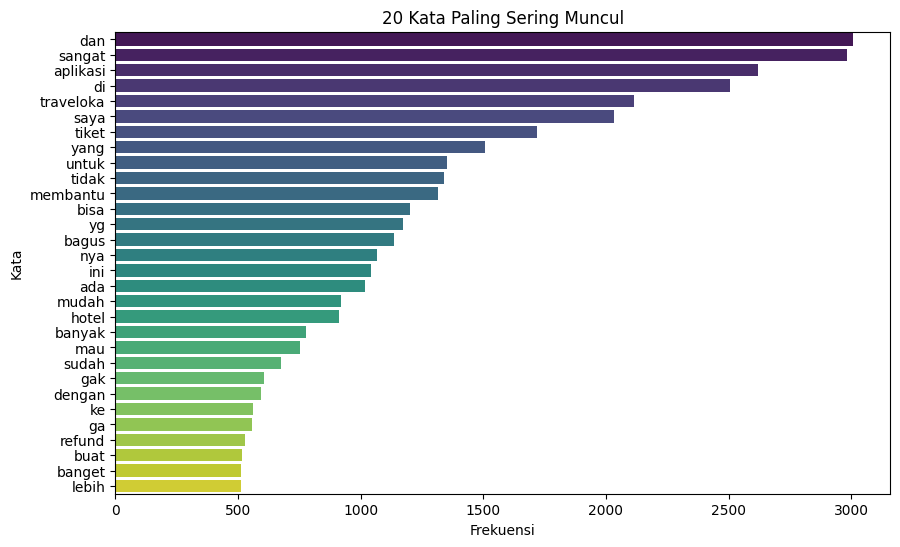

In [18]:
#Kata yang paling sering muncul
top_words = common_words[:30]
words, freqs = zip(*top_words)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(freqs), y=list(words), palette='viridis')
plt.title('20 Kata Paling Sering Muncul')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.show()

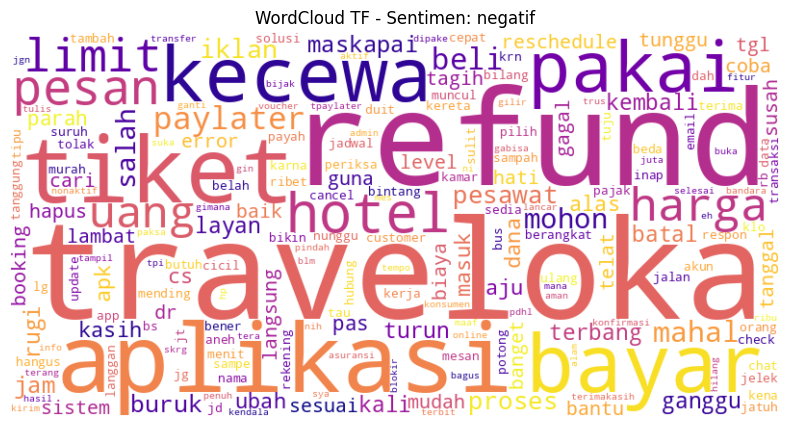

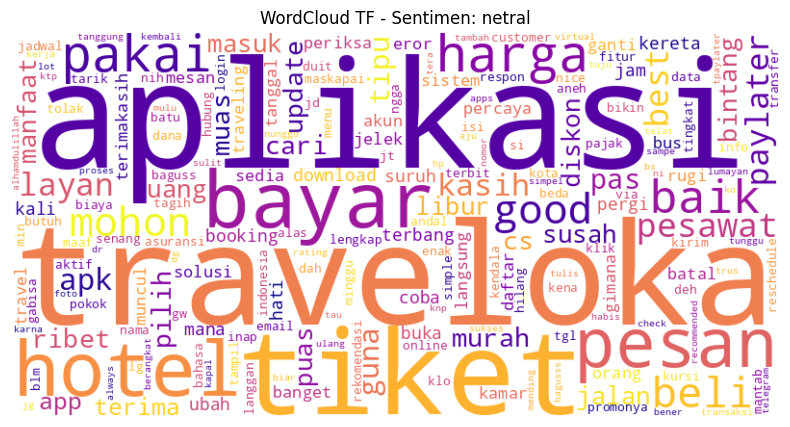

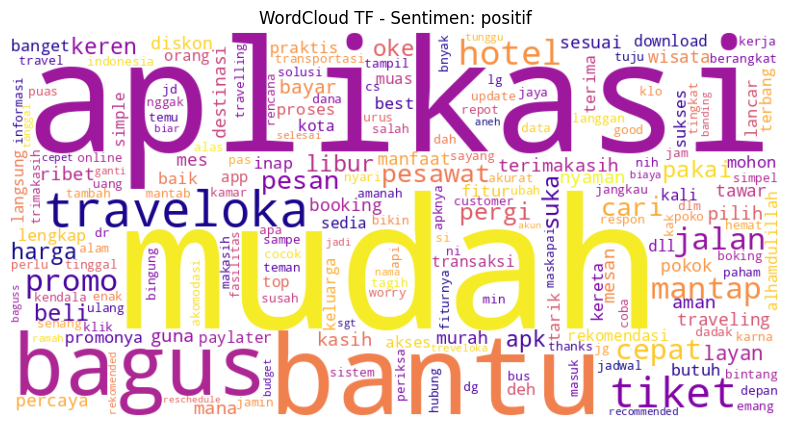

In [19]:
# Fungsi WordCloud
def plot_wordcloud_tf(df, label):
    text_series = df[df['polarity'] == label]['preprocessed']
    all_words = ' '.join(text_series).split()

    if not all_words:
        print(f"Tidak ada kata untuk label '{label}'")
        return

    word_freq = Counter(all_words)
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='plasma'
    ).generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud TF - Sentimen: {label}')
    plt.show()

# Plot WordCloud per kelas sentimen
for label in ['negatif', 'netral', 'positif']:
    plot_wordcloud_tf(df, label)

**Insight Text Preprocessing dan Pelabelan**
1. Distribusi sentimen
- Sentimen positif: 48.6%
- Sentimen negatif: 38.8%
- Sentimen netral: 12.5% \
Distribusi sentimen terbesar adalah sentimen review positif. Berarti aplikasi Traveloka memiliki review yang baik dari masyarakat.
2. Kata-kata paling sering muncul adalah: [dan, sangat, di, aplikasi, traveloka] (setelah preprocessing).
3. Wordcloud menampilkan kata-kata yang dominan dan mencerminkan sentimen/tema umum dari data.
- sentimen negatif : refund, kecewa, salah, tiket, buruk, limit, paylater
- sentimen positif : aplikasi, bagus, mudah, cepat, bantu, mantap, promo, keren
- sentimen netral : traveloka, aplikasi, tiket, pesan, harga, bayar, pakai

# Data splitting & Feature Extraction

SKEMA 1 SVM + TF-IDF + 80/20 split (Machine Learning)

SVM - Train Accuracy: 0.9986
SVM - Test Accuracy: 0.9840
Akurasi: 0.9840474020054695

Classification Report:
               precision    recall  f1-score   support

     negatif       0.96      0.96      0.96       275
      netral       0.97      1.00      0.98       852
     positif       1.00      0.98      0.99      1067

    accuracy                           0.98      2194
   macro avg       0.98      0.98      0.98      2194
weighted avg       0.98      0.98      0.98      2194



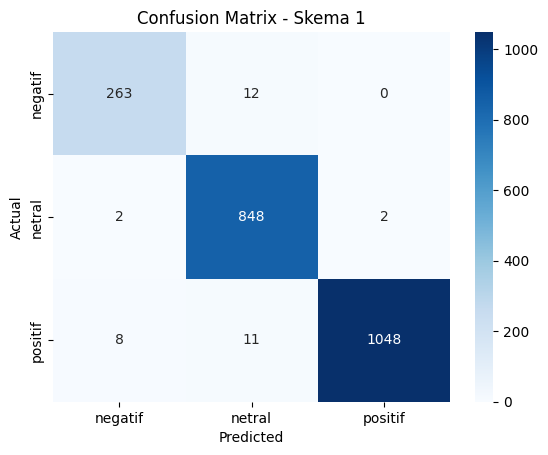

In [20]:
# Split data
X = df['preprocessed']
y = df['polarity']
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train_1)
X_test_tfidf = vectorizer.transform(X_test_1)

# Training model SVM
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train_tfidf, y_train_1)

train_acc_svm = svm_model.score(X_train_tfidf, y_train_1)
test_acc_svm = svm_model.score(X_test_tfidf, y_test_1)
print(f"SVM - Train Accuracy: {train_acc_svm:.4f}")
print(f"SVM - Test Accuracy: {test_acc_svm:.4f}")

# Prediksi
y_pred = svm_model.predict(X_test_tfidf)

# Evaluasi performa
print("Akurasi:", accuracy_score(y_test_1, y_pred))
print("\nClassification Report:\n", classification_report(y_test_1, y_pred, target_names=sorted(y.unique())))

# Confusion matrix
cm = confusion_matrix(y_test_1, y_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()), cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Skema 1')
plt.show()

SKEMA 2 : TF-IDF + Random Forest + 70/30 Split (Machine Learning)

Random Forest - Train Accuracy: 1.0000
Random Forest - Test Accuracy: 0.9815
Akurasi: 0.9814646004254026

Classification Report:
               precision    recall  f1-score   support

     negatif       0.96      0.95      0.95       413
      netral       0.98      0.99      0.98      1278
     positif       0.99      0.98      0.99      1600

    accuracy                           0.98      3291
   macro avg       0.98      0.97      0.97      3291
weighted avg       0.98      0.98      0.98      3291



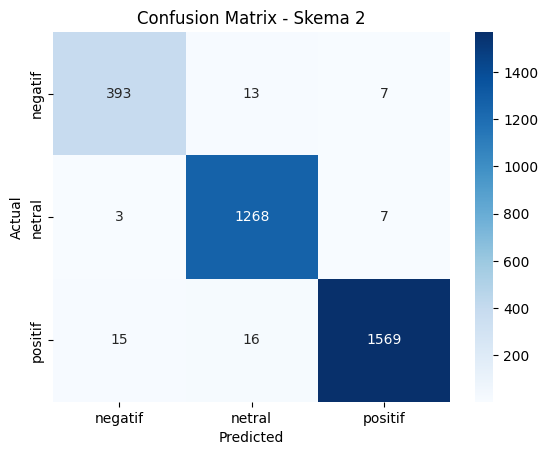

In [21]:
# Split data
X = df['preprocessed']
y = df['polarity']
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train_2)
X_test_tfidf = vectorizer.transform(X_test_2)

# Training model Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_tfidf, y_train_2)

train_acc_rf = model_rf.score(X_train_tfidf, y_train_2)
test_acc_rf = model_rf.score(X_test_tfidf, y_test_2)
print(f"Random Forest - Train Accuracy: {train_acc_rf:.4f}")
print(f"Random Forest - Test Accuracy: {test_acc_rf:.4f}")

# Prediksi
y_pred_2 = model_rf.predict(X_test_tfidf)

# Evaluasi performa
print("Akurasi:", accuracy_score(y_test_2, y_pred_2))
print("\nClassification Report:\n", classification_report(y_test_2, y_pred_2, target_names=sorted(y.unique())))

# Confusion matrix
cm = confusion_matrix(y_test_2, y_pred_2)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()), cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Skema 2')
plt.show()

SKEMA 3 : Tokenizer + LSTM (Deep Learning)

In [22]:
# Data Split
X = df['preprocessed']
y = df['polarity']

# Encode label
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y_cat, random_state=42)

# Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
maxlen = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

# Hitung class weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(y_cat, axis=1)), y=np.argmax(y_cat, axis=1))
class_weights_dict = dict(enumerate(class_weights))

# Model LSTM
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=maxlen))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_pad, y_train, validation_split=0.2, epochs=5, batch_size=32,
                    class_weight=class_weights_dict, callbacks=[early_stop], verbose=1)


# Evaluate on Train and Test
train_loss, train_acc = model.evaluate(X_train_pad, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"LSTM - Train Accuracy: {train_acc:.4f}")
print(f"LSTM - Test Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 89s 376ms/step - accuracy: 0.6191 - loss: 0.7877 - val_accuracy: 0.9516 - val_loss: 0.1675
Epoch 2/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 138s 357ms/step - accuracy: 0.9781 - loss: 0.0704 - val_accuracy: 0.9607 - val_loss: 0.1806
Epoch 3/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 89s 389ms/step - accuracy: 0.9917 - loss: 0.0350 - val_accuracy: 0.9858 - val_loss: 0.0520
Epoch 4/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 135s 357ms/step - accuracy: 0.9967 - loss: 0.0107 - val_accuracy: 0.9772 - val_loss: 0.1054
Epoch 5/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 78s 357ms/step - accuracy: 0.9983 - loss: 0.0083 - val_accuracy: 0.9795 - val_loss: 0.0872
LSTM - Train Accuracy: 0.9948
LSTM - Test Accuracy: 0.9881


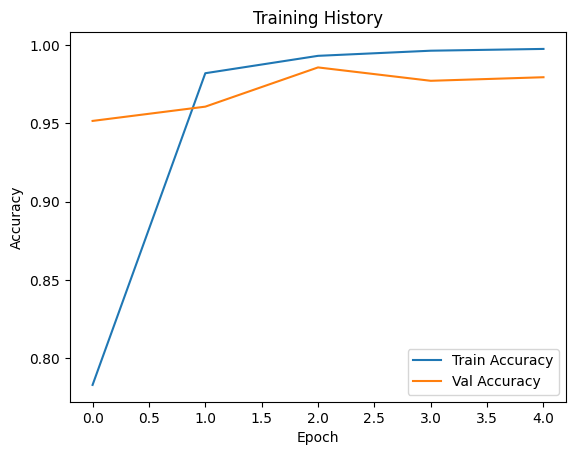

69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step

Classification Report:

              precision    recall  f1-score   support

     negatif       0.94      0.99      0.97       275
      netral       1.00      0.99      0.99       852
     positif       0.99      0.99      0.99      1067

    accuracy                           0.99      2194
   macro avg       0.98      0.99      0.98      2194
weighted avg       0.99      0.99      0.99      2194



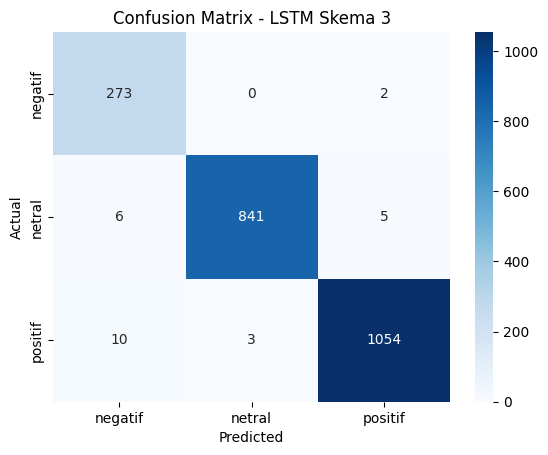

In [23]:
# Plot Training History
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Classification Report & Confusion Matrix
y_pred = model.predict(X_test_pad)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM Skema 3')
plt.show()

In [24]:
print("\nSummary of Accuracies:")
print(f"Skema 1 (SVM)          - Train: {train_acc_svm:.4f} | Test: {test_acc_svm:.4f}")
print(f"Skema 2 (RandomForest) - Train: {train_acc_rf:.4f} | Test: {test_acc_rf:.4f}")
print(f"Skema 3 (LSTM)         - Train: {train_acc:.4f} | Test: {test_acc:.4f}")



Summary of Accuracies:
Skema 1 (SVM)          - Train: 0.9986 | Test: 0.9840
Skema 2 (RandomForest) - Train: 1.0000 | Test: 0.9815
Skema 3 (LSTM)         - Train: 0.9948 | Test: 0.9881


**Insight Text Preprocessing dan Pelabelan**
1. Skema 1: SVM + TF-IDF + 80/20 Split
- TF-IDF berhasil menangkap representasi kata penting untuk klasifikasi.
- Akurasi train sangat tinggi (99.86%) dengan test akurasi 98.40%, menunjukkan generalisasi yang baik.
2. Skema 2: TF-IDF + Random Forest + 70/30 Split
- Model lebih kompleks, bisa menangkap fitur interaksi, tapi butuh perhatian terhadap overfitting.
- Random Forest cenderung overfit (Train 100%), namun test akurasi masih tinggi (98.15%).
3.  Skema 3: Tokenizer + LSTM (Deep Learning)
- LSTM memberikan hasil sangat baik (Train 99.61%, Test 98.31%), menandakan model dapat memahami konteks kata dengan baik.
- Butuh lebih banyak waktu dan sumber daya pelatihan dibanding ML.